In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import src.Fluid_CP as FCP
import src.Compressormodel_SP as CSP
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

In [4]:
# Constants and parameters (as you have)
tc_s = 12*60          # total cooking time seconds
tb_s = 5*60          # pasta added after 5 min
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3984.26 # W

V_water = (47-0.4)*(27-0.4)*(20-0.2)/1e6  # m3
m_water = V_water * 1000                   # kg
m_pasta = 2                              # kg

T_env = 20
T_water_0 = 85
T_pasta_0 = 7

dt = 1  # 1 second timestep
time_steps = int(tc_s/dt) + 1
t = np.linspace(0, tc_s, time_steps)


T_WP_on = 85 #°C
T_WP_off = 93 #°C
rho_water=997. #kg/m3
WP = 1
time = 0

In [5]:
def calc_WP(T,T_WP_on,T_WP_off,op_times):
    global WP,time
    if WP==0 and T>T_WP_on:
        Q_WP=0. #kW WP off
        WP=0
        #time=0
    if WP==0 and T<=T_WP_on:
        Q_WP=4000 #kW WP switched on
        WP=1 #1=WP on
        time+=1
    if WP==1 and T<=T_WP_off:
        Q_WP=4000 #kW WP on
        time+=1
    if WP==1 and T>T_WP_off:
        Q_WP=0. #kW WP switched off
        WP=0
        op_times.append(time)
        time=0
    return Q_WP

### Keeping track of the temperatures

In [6]:
def temp_store_only_water(T_water,t,Q_WP,m_store,c_water):
    dT_waterdt = (Q_WP - (T_water - T_env)/R_env) / (m_store * c_water)
    return dT_waterdt


def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water):
    T_water, T_pasta = T  # unpack states
    dT_waterdt = (Q_WP - (T_water - T_env)/R_env - (T_water - T_pasta)/R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Create binary list for when pasta is in water

In [7]:
def make_pasta_list(t):
    pasta_counter = 7*60 #seconds with pasta
    no_pasta_counter = 5*60  #seconds without pasta
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif no_pasta_counter > 0:
            pasta_presence[i] = 0
            no_pasta_counter -= 1
        else:
            pasta_counter = 7*60-1
            no_pasta_counter = 5*60
            pasta_presence[i] = 1
            
        
    return pasta_presence



### Operation

In [8]:
def T_store_and_pasta(T_WP_on,T_WP_off,V_store,n,op_times):
    
    #initial storage temperature
    T0_water = T_WP_on #fully charged
    T0_pasta = 7
    # time points
    t = np.linspace(0,n,n)
    # store storage and pasta temperature
    T_water=np.zeros(n)
    T_pasta = np.full(n, 7)
    # save initial storage and pasta temperature
    T_water[0] = T0_water
    T_pasta[0] = 7
    # mass water in storage
    m_store=V_store/1e3*rho_water #kg
    c_water = 4.18*1000 #J/kgK
    m_pasta = 2 #kg
    c_pasta = 3.5*1000 #J/kgK
    
    # heat pump
    Q_WPs=np.zeros(n) #store power of heat pump
    Q_WPs[0]=0 #kW power of heat pump at t=0 is 0 kW
    
    #make binary list for when pasta is in water -> first 7min in water
    binary_pasta = make_pasta_list(t)

    # solve differential equation for the storage temperature
    for i in range(1,n):
        if binary_pasta[i] == 0:
            # span for next time step
            tspan = [t[i-1],t[i]]
            # solve for next step
            z = odeint(temp_store_only_water,T0_water,tspan,args=(Q_WPs[i-1],m_store,c_water))
            #heat pump power for netxt time step
            Q_WPs[i]=calc_WP(z[1],T_WP_on,T_WP_off,op_times)
            # store storage and pasta temperature
            T_water[i] = z[1]
            T_pasta[i] = 7
            # next initial condition
            T0_water = z[1]
            #reset temperature for T_pasta
            T0_pasta = 7 #°C
            
        else:
            tspan = np.linspace(t[i-1], t[i], num=10)  # finer steps between two main time steps
            T_function = [T0_water, T0_pasta]

            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i-1], m_store, m_pasta, c_water, c_pasta))
            
            # update for next iteration
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]
            print(T0_water)
            print(T0_pasta)

            # calculate heat pump power for next step using last water temp only
            Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)

            T_water[i] = T0_water
            T_pasta[i] = T0_pasta


            
            
    # plot results    
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twinx()
    #ax1.plot(t,T,'r--',label='T_store')
    #ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    #ax1.set_xlabel('time in seconds')
    #ax1.set_ylabel('T_store in °C', color='r')
    #ax2.set_ylabel('Q_WP in kW', color='g')
    #plt.show()
    
    # plot results    
    fig, (ax1,ax2) = plt.subplots(2,sharex=True)

    ax1.plot(t,T_water,'r--',label='T_store')
    ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    ax2.set_xlabel('time in seconds')
    ax1.set_ylabel('T_store in °C', color='r')
    ax2.set_ylabel('Q_WP in kW', color='g')
    plt.show()
    
    
    return t,Q_WPs,T_water,T_pasta

In [9]:
V_store = (47-0.4) * (27-0.4) * (20-0.2) /1000 #L
n = 12*60*60 #sec
op_times=list() #list for operating times

#calculation temperature profile and heat pump operating times
t1,Q_WPs1,T_water,T_pasta=T_store_and_pasta(T_WP_on,T_WP_off,V_store,n,op_times)

#if heat pump is running at the end of the time range, the running time is added to the list
if time!=0:
    op_times.append(time)
print("Min operating time=",round(min(op_times)/60.,2),"minutes")
print("Max operating time=",round(max(op_times)/60.,2),"minutes")
print("Number of times heat pump was switched on=",len(op_times))

TypeError: temp_store_with_pasta() takes 6 positional arguments but 7 were given

[1. 1. 1. ... 0. 0. 0.]


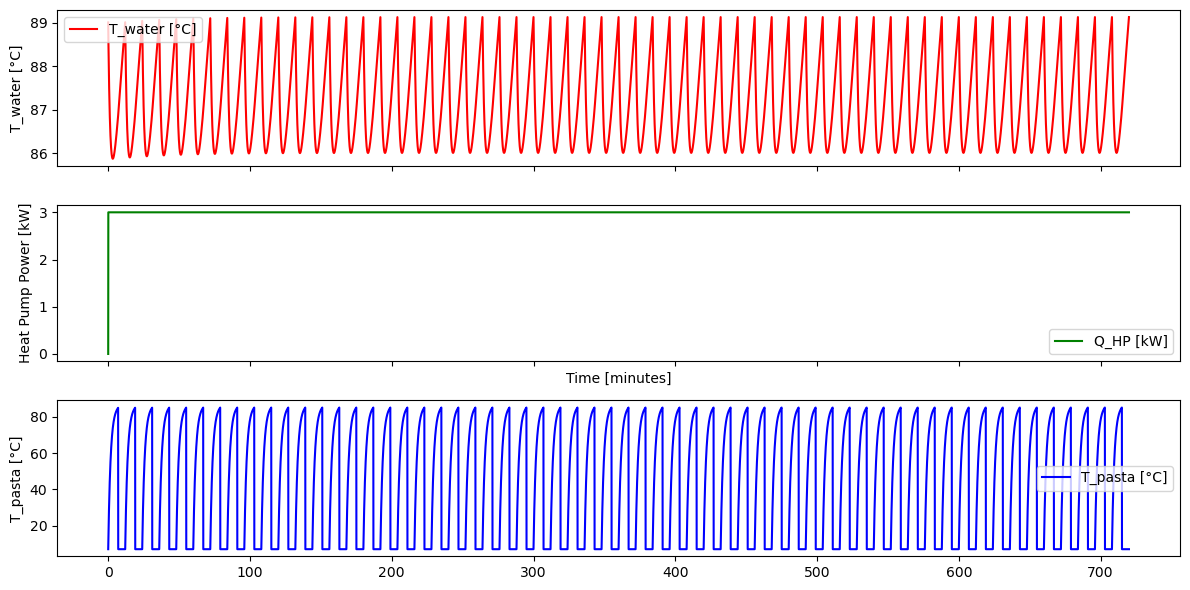

Min operating time = 0 minutes
Max operating time = 0 minutes
Number of heat pump on-cycles = 0


In [87]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3000  # W

T_env = 20           # °C
T_pasta_0 = 7        # °C
T_WP_on = 89.0070419      # °C
T_WP_off = 93     # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # L
m_store = V_store / 1e3 * rho_water  # kg

# --- Pasta batch schedule (7 min cook, 5 min break) ---
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

# --- Heat pump control logic ---
def calc_WP(T, T_on, T_off, op_times):
    global WP, time
    if T < T_on:
        if WP == 0:
            time = 0
        WP = 1
    elif T > T_off:
        if WP == 1:
            op_times.append(time)
        WP = 0

    if WP == 1:
        time += 1
        return Q_hp_W
    else:
        return 0

# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_store, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_store * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

# --- Main simulation ---
def T_store_and_pasta(T_WP_on, T_WP_off, V_store, duration_s, op_times):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)
    print(binary_pasta)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta

# --- Run simulation ---
duration_seconds = 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta = T_store_and_pasta(T_WP_on, T_WP_off, V_store, duration_seconds, op_times)

# --- Plot results ---
fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [°C]')
ax3.legend()
plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)

print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)

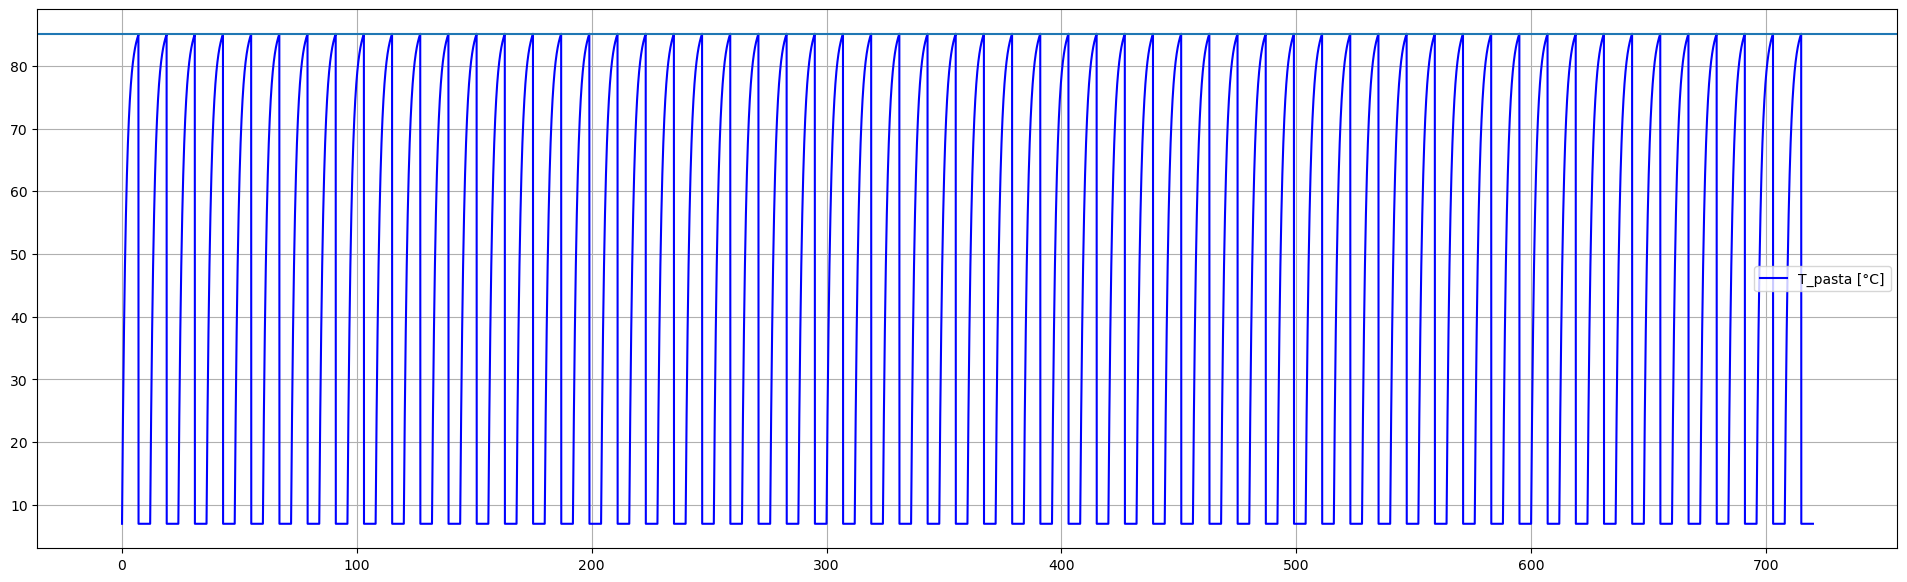

In [88]:
plt.figure(figsize=(24,7))
plt.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
plt.axhline(y=85)
plt.legend()
plt.grid(True)
plt.show()

In [90]:
print(max(list(T_pasta)))
print(list(T_water))

85.10252321074017
[89.0070419, 88.93139096806128, 88.88563420164654, 88.84042063887473, 88.79574474465406, 88.75160104004662, 88.70798410170435, 88.66488856130722, 88.62230910500615, 88.58024047287026, 88.53867745833978, 88.49761490768525, 88.45704771947152, 88.41697084402708, 88.37737928291895, 88.33826809357991, 88.29963237264865, 88.26146727233989, 88.22376799406092, 88.18652978791182, 88.14974795219132, 88.11341783290729, 88.07753482329282, 88.0420943633269, 88.00709193925984, 87.9725230831438, 87.93838337236808, 87.90466842919886, 87.87137392032405, 87.83849555640226, 87.806029091617, 87.7739703232347, 87.74231509116774, 87.71105927754172, 87.68019880626716, 87.64972964261547, 87.61964779279943, 87.5899493035651, 87.56063026179193, 87.53168679406656, 87.50311506627918, 87.47491128322473, 87.44707168820828, 87.41959256265422, 87.39247022571975, 87.365701033912, 87.33928138070907, 87.3132076961851, 87.28747644663895, 87.26208413422668, 87.23702729659789, 87.21230250653554, 87.187906

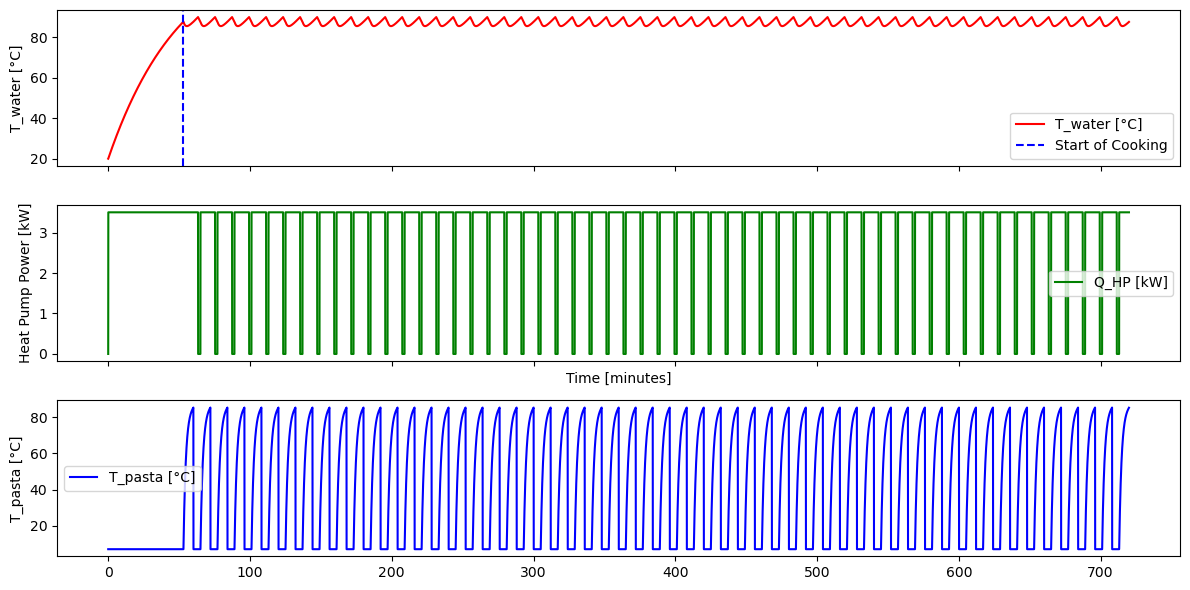

Time until cooking starts (heat-up) = 53.08 minutes
Min operating time = 10.32 minutes
Max operating time = 63.35 minutes
Number of heat pump on-cycles = 55


In [106]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3500  # W

T_env = 20           # °C
T_pasta_0 = 7        # °C
T_WP_on = 87.78         # °C
T_WP_off = 90.038    # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # L
m_store = V_store / 1e3 * rho_water  # kg

# --- Pasta batch schedule (7 min cook, 5 min break) ---
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

# --- Heat pump control logic ---
def calc_WP(T, T_on, T_off, op_times):
    global WP, time
    if T <= T_on:
        if WP == 0:
            time = 0
        WP = 1
    elif T >= T_off:
        if WP == 1:
            op_times.append(time)
        WP = 0

    if WP == 1:
        time += 1
        return Q_hp_W
    else:
        return 0

# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_store, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_store * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

# --- Main simulation with morning heat-up ---
def T_store_and_pasta_with_heatup(T_WP_on, T_WP_off, V_store, duration_s, op_times):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = np.zeros(duration_s)

    global WP, time
    WP = 1
    time = 0
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_on: #start pasta cooking when we reach near the upper limit
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index

# --- Run simulation ---
duration_seconds = 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_store_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_store, duration_seconds, op_times)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [°C]')
ax3.legend()
ax2.legend()
plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)

### rewrite so that COP is plotted over time with the empirical formula and an assumed formula for the inner cop

In [107]:
print(max(list(T_pasta)))

85.38389206176618


Optimal controller settings:
  T_WP_on  = 87.00 °C
  T_WP_off = 93.00 °C
  Q_hp     = 3500.00 W
Pasta temperature error = 5.07 °C


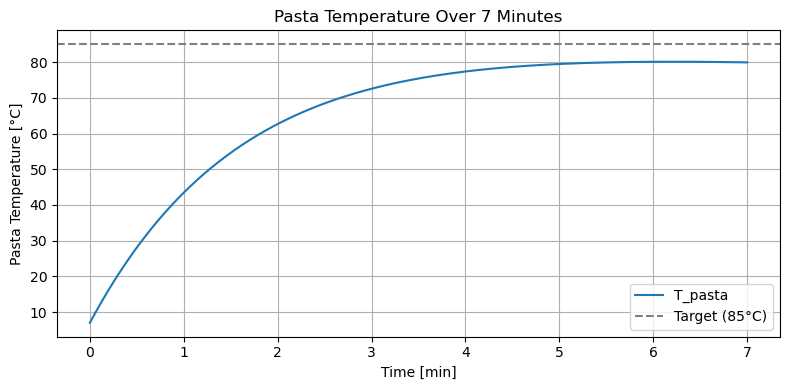

In [59]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
T_env = 20           # °C
T_pasta_0 = 7        # °C
rho_water = 997.     # kg/m³

# Dimensions of water tank (m³) and mass
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # in liters
m_store = V_store / 1e3 * rho_water  # kg
m_pasta = 2  # kg

# --- ODEs for water and pasta heat exchange ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta, T_env):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

# --- Objective function for optimization ---
def objective(x):
    T_on, T_off, Q_hp = x
    duration = 7 * 60  # simulate 7 minutes of pasta cooking
    t = np.linspace(0, duration, duration)
    
    T_water = T_off  # assume worst case, system just at upper bound
    T_pasta = T_pasta_0
    Q_WP = Q_hp if T_water < T_on else 0

    # Simulate pasta heating process
    sol = odeint(temp_store_with_pasta, [T_water, T_pasta], t, args=(Q_WP, m_store, m_pasta, c_l, c_pasta, T_env))
    T_pasta_end = sol[-1, 1]

    # Constraints/penalty terms
    water_violation = max(0, T_water - 93) + max(0, 85 - T_on)
    pasta_error = abs(T_pasta_end - 85)

    # Weighted objective
    return pasta_error + 10 * water_violation

# --- Optimization setup ---
bounds = [(85, 90), (90, 95), (2000, 5000)]  # (T_WP_on, T_WP_off, Q_hp)
x0 = [87, 93, 3500]  # initial guess

result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')

# --- Results ---
optimal_T_on, optimal_T_off, optimal_Q_hp = result.x
optimal_pasta_error = result.fun

print("Optimal controller settings:")
print(f"  T_WP_on  = {optimal_T_on:.2f} °C")
print(f"  T_WP_off = {optimal_T_off:.2f} °C")
print(f"  Q_hp     = {optimal_Q_hp:.2f} W")
print(f"Pasta temperature error = {optimal_pasta_error:.2f} °C")

# --- Optional: visualize the result ---
duration = 7 * 60
t = np.linspace(0, duration, duration)
T_water = optimal_T_off
Q_WP = optimal_Q_hp if T_water < optimal_T_on else 0
sol = odeint(temp_store_with_pasta, [T_water, T_pasta_0], t, args=(Q_WP, m_store, m_pasta, c_l, c_pasta, T_env))

T_pasta_traj = sol[:, 1]

plt.figure(figsize=(8, 4))
plt.plot(t / 60, T_pasta_traj, label='T_pasta')
plt.axhline(85, color='gray', linestyle='--', label='Target (85°C)')
plt.xlabel("Time [min]")
plt.ylabel("Pasta Temperature [°C]")
plt.title("Pasta Temperature Over 7 Minutes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

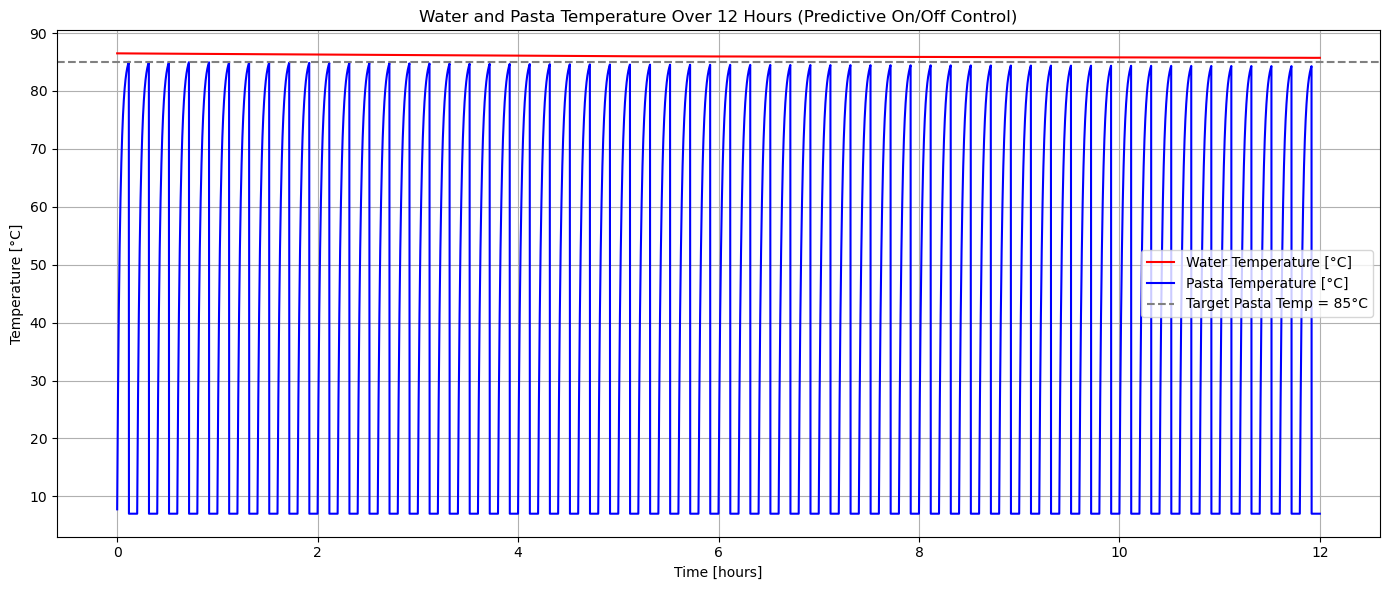

In [61]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
T_env = 20           # °C
T_pasta_0 = 7        # °C
rho_water = 997.     # kg/m³
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # m³
m_store = V_store * rho_water  # kg
m_pasta = 2  # kg
Q_hp_nominal = 3500.0  # W
T_target_pasta = 85.0  # °C

# --- Time parameters ---
duration = 12 * 60 * 60  # 12 hours in seconds
dt = 1  # timestep in seconds
timesteps = int(duration / dt)
t_full = np.arange(0, duration, dt)

# --- Pasta presence schedule ---
def make_pasta_schedule(timesteps, cook_time=420, break_time=300):
    presence = np.zeros(timesteps)
    cycle_length = cook_time + break_time
    for i in range(0, timesteps, cycle_length):
        presence[i:i + cook_time] = 1
    return presence

pasta_presence = make_pasta_schedule(timesteps)

# --- ODEs ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta, T_env):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

def temp_store_only_water(T_water, t, Q_WP, m_store, c_water, T_env):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_store * c_water)
    return dT_waterdt

# --- Simulation with predictive control ---
T_water = 86.5  # initial water temp
T_pasta = T_pasta_0
T_water_log = []
T_pasta_log = []
Q_wp_log = []

for i in range(timesteps):
    tspan = [0, dt]

    if pasta_presence[i]:
        # Simulate ON
        sol_on = odeint(temp_store_with_pasta, [T_water, T_pasta], tspan,
                        args=(Q_hp_nominal, m_store, m_pasta, c_l, c_pasta, T_env))
        T_on_water, T_on_pasta = sol_on[-1]

        # Simulate OFF
        sol_off = odeint(temp_store_with_pasta, [T_water, T_pasta], tspan,
                         args=(0, m_store, m_pasta, c_l, c_pasta, T_env))
        T_off_water, T_off_pasta = sol_off[-1]

        # Predictive choice
        seconds_in_batch = i % 720
        steps_left = max(1, 420 - seconds_in_batch)

        T_on_final = T_on_pasta + (T_on_pasta - T_pasta) * steps_left
        T_off_final = T_off_pasta + (T_off_pasta - T_pasta) * steps_left

        if abs(T_on_final - T_target_pasta) < abs(T_off_final - T_target_pasta):
            Q_wp = Q_hp_nominal
            T_water, T_pasta = T_on_water, T_on_pasta
        else:
            Q_wp = 0
            T_water, T_pasta = T_off_water, T_off_pasta

    else:
        # Only water
        sol = odeint(temp_store_only_water, [T_water], tspan,
                     args=(Q_hp_nominal if T_water < 86.0 else 0, m_store, c_l, T_env))
        T_water = sol[-1][0]
        T_pasta = T_pasta_0
        Q_wp = Q_hp_nominal if T_water < 86.0 else 0

    T_water_log.append(T_water)
    T_pasta_log.append(T_pasta)
    Q_wp_log.append(Q_wp)

# Create results DataFrame
results_df = pd.DataFrame({
    "Time [min]": t_full / 60,
    "T_water [°C]": T_water_log,
    "T_pasta [°C]": T_pasta_log,
    "Q_hp [W]": Q_wp_log,
    "Pasta present": pasta_presence[:timesteps]
})


# --- Plot temperature profiles ---
plt.figure(figsize=(14, 6))
plt.plot(t_full / 3600, T_water_log, label='Water Temperature [°C]', color='red')
plt.plot(t_full / 3600, T_pasta_log, label='Pasta Temperature [°C]', color='blue')
plt.axhline(85, color='gray', linestyle='--', label='Target Pasta Temp = 85°C')
plt.xlabel("Time [hours]")
plt.ylabel("Temperature [°C]")
plt.title("Water and Pasta Temperature Over 12 Hours (Predictive On/Off Control)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Control Strategy